# Algorithmic Trading Strategy Challenge

Name: Shyam Parikh

In this challenge, your task is to design an algorithmic trading strategy using the stocks in the provided portfolio.
    
You may use yfinance to source data for the stocks within the period defined in the dummy_data.xlsx file.

You are not allowed to use a simple "buy and hold" strategy. Be creative and implement a more complex strategy that will maximize profit and minimize risk.

Your solution can be based on machine learning, technical analysis, or any other approach you find suitable.

Be creative and demonstrate your coding ability in this challenge.

In addition to implementing your strategy during this time period, you will also need to graph the profit/loss and liquidity ratio of the strategy over time.

Feel free to add code blocks and markdown blocks as needed, however, ensure specified logic is contained within their respective headers in the notebook.


## Strategy Implementation

In [19]:
## Libraries imported
from shyam_parikh_portfolio_analysis import PortfolioAnalysis 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential
from keras.optimizers import Adam
from keras import layers
from keras.layers import Input, Dense, Dropout,Flatten
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr 
import yfinance as yf
from functools import reduce
from keras.callbacks import EarlyStopping
from pypfopt import HRPOpt
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import datetime
yf.pdr_override()


### Pulling in Stock Tickers from Portfolio Analysis DataFrame

In [20]:
stocks = PortfolioAnalysis("dummy_data.xlsx").asset_values['Stock']
tickers = list(stocks[:-1].values)
tickers.remove("Cash")

c:\Users\shyam\OneDrive\Documents\SSMIF Coding Challenge Fall 2023\Fall2023 Challenge\shyam_parikh_portfolio_analysis.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock_data = stock.history(start= df['Date'][0], end= date)['Close'][-1]


### Optimizing the Portfolio using Hierarchial Risk Parity to Maximize Sharpe
Used the following two code blocks from https://builtin.com/data-science/portfolio-optimization-python in order to optimize the assets in my portfolio. 

In [21]:
START_DATE = '2023-03-31' # Stock data start date 
END_DATE = '2023-09-20' # Stock data end date
def get_stock(ticker):
    data = pdr.get_data_yahoo(f"{ticker}",START_DATE,END_DATE)
    data[f'{ticker}'] = data["Close"]
    data = data[[f'{ticker}']] 
    print(data.head())
    return data 

def combine_stocks(tickers):
    data_frames = []
    for i in tickers:
        data_frames.append(get_stock(i))
        
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), data_frames)
    print(df_merged.head())
    return df_merged
portfolio = combine_stocks(tickers)
    

[*********************100%%**********************]  1 of 1 completed
                  AAPL
Date                  
2023-03-31  164.899994
2023-04-03  166.169998
2023-04-04  165.630005
2023-04-05  163.759995
2023-04-06  164.660004
[*********************100%%**********************]  1 of 1 completed
                  AMZN
Date                  
2023-03-31  103.290001
2023-04-03  102.410004
2023-04-04  103.949997
2023-04-05  101.099998
2023-04-06  102.059998
[*********************100%%**********************]  1 of 1 completed
                  META
Date                  
2023-03-31  211.940002
2023-04-03  213.070007
2023-04-04  214.720001
2023-04-05  211.479996
2023-04-06  216.100006
[*********************100%%**********************]  1 of 1 completed
                  MSFT
Date                  
2023-03-31  288.299988
2023-04-03  287.230011
2023-04-04  287.179993
2023-04-05  284.339996
2023-04-06  291.600006
[*********************100%%**********************]  1 of 1 completed
           

### Backtesting Against the Market

I used Hierarchial Risk Parity to optimize my portfolio and maximize the Sharpe Ratio. HRP is based on the correlation factor between multiple stocks. I was debating whether to use this or use mean variance optimization, but mean variance optimization is strictly maximizing Sharpe Ratio with minimizing the diversification of the portfolio. 


In [22]:

performance = portfolio.pct_change()
hrp = HRPOpt(performance)
hrp_weights = hrp.optimize()

hrp.portfolio_performance(verbose=True)
weights = dict(hrp_weights)
print(weights)
latest_prices = get_latest_prices(portfolio)
da_hrp = DiscreteAllocation(hrp_weights, latest_prices, total_portfolio_value=20000)
allocation, leftover = da_hrp.greedy_portfolio()
print("Hierarchial Risk Parity allocation :", allocation)


Expected annual return: 29.3%
Annual volatility: 10.9%
Sharpe Ratio: 2.51
{'AAPL': 0.061870186837459776, 'AMZN': 0.05871762363827903, 'GOOG': 0.05222277082214749, 'JNJ': 0.2206718038134339, 'JPM': 0.1714697884557604, 'META': 0.03457917288250221, 'MSFT': 0.0448171476889612, 'NVDA': 0.021018120146522747, 'SPY': 0.1989322926683314, 'TSLA': 0.010774823773455863, 'XOM': 0.12492626927314596}
Hierarchial Risk Parity allocation : {'JNJ': 27, 'SPY': 9, 'JPM': 23, 'XOM': 22, 'AAPL': 7, 'AMZN': 8, 'GOOG': 7, 'MSFT': 3, 'META': 2, 'NVDA': 1, 'TSLA': 1}


c:\Users\shyam\AppData\Local\Programs\Python\Python311\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.59680361 0.59680361 0.59680361 0.59680361 0.59680361]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


### Building an LSTM Model for each Specific Stock 

I picked an LSTM model because they tend to have stronger predictions for time series data.

For this model, I am assuming that there will be a lag in the selling of stocks.

In [23]:
START_DATE = '2020-09-20' # Stock data start date 
END_DATE = '2023-09-20' # Stock data end date
def buildNeuralNetwork(stock : str, START_DATE:str,END_DATE:str):
    ##Grabbing in the Data
    df = pdr.get_data_yahoo(stock, START_DATE, END_DATE)
    closingPrices = list(df['Adj Close'])
    
    ## Model will predict based on the price movements of its previous 5 days
    data = {
            'date':df.index[:-5],
            '5thPriceIndicator' : closingPrices[:-5],
            '4thPriceIndicator' : closingPrices[1:-4],
            '3rdPriceIndicator': closingPrices[2:-3],
            '2ndPriceIndicator':closingPrices[3:-2],
            '1stPriceIndicator': closingPrices[4:-1],
            'Target' :closingPrices[5:]
            } 
    newDf = pd.DataFrame(data)
    ## In the case of this 
    df_as_np = newDf.to_numpy()
    dates = df_as_np[:,0]
    ## y represents target Price( the actual stock Price for that day)
    y = df_as_np[:, -1].astype(np.float32)
    ## X represents the 4 prices before the target Price)
    middle_matrix = df_as_np[:, 1:-1]
    X = (middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))).astype(np.float32)
    ## Scaling the Dataset to Training and Test Data
    X_train,X_test, dates_train,dates_test = train_test_split(X,dates,test_size = 0.15,shuffle = False)
    X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = 0.15,shuffle = False)
    ## Separating the Training Set into Training and Validation Data
    X_train,X_val, y_train,y_val = train_test_split(X_train,y_train,test_size = 0.15,shuffle = False)

    model = Sequential([layers.Input((5,1)),
                     layers.LSTM(64),
                     layers.Dense(32,activation = 'relu'),
                     layers.Dense(32,activation = 'relu'),
                     layers.Dense(32,activation = 'relu'),
                     layers.Dense(32,activation = 'relu'),
                     layers.Dense(1)])
    model.compile(loss = 'mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_squared_error'])    
    ### Used to minimize overfitting
    monitor = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=15,  mode='auto', restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val),callbacks= [monitor],epochs=1000)
    
    train_predictions = model.predict(X_train).flatten()
    val_predictions = model.predict(X_val).flatten()
    test_predictions = model.predict(X_test).flatten()
    plt.figure()

    plt.plot(dates_test,test_predictions)
    plt.plot(dates_test,y_test)
    plt.title(f"{stock} Price Chart")
    plt.legend(['Prediction Prices', 'Actual Prices'])
    plt.show()
    neuralNetSymbol = stock + "_nn"
    return {neuralNetSymbol:test_predictions, stock: y_test,"dates" : dates_test}
def calcReturnsWithNoLag(dictData:dict,weights : dict) -> pd.DataFrame:
    unrealized = dictData
    data = {}
    values = list(unrealized.items())
    data['Dates']= values[-1][1]   
    first,second = values[0][0],values[1][0]
    data[first] = values[0][1]   
    data[second] = values[1][1]
    test = pd.DataFrame(data)
    specificWeight = weights.get(second)
    totalCash = specificWeight*200000
    #########################################################
    ## For This Code, I  calculated unrealized gains and losses 
    ## for each stock. When writing my code, I assumed that there
    ## would be some sort of lag when executing orders
    #########################################################
    x = list(test.columns)
    values = []
    buySell = []
    cash = []
    assets = []
    initialReturns = 0
    holding = True
    for index, row in test.iterrows():
        if (row[x[1]] < row[x[2]]):
            if(holding and index !=0):
                previousPrice = float(test.loc[index-1][x[2]])
                initialReturns = (row[x[2]] - previousPrice) + initialReturns 
                values.append(initialReturns)
                assets.append(shares*row[x[2]])
                cash.append(totalCash)
                buySell.append(0)
            elif(holding and index == 0):
                initialReturns = initialReturns
                shares = int(totalCash/row[x[2]])
                moneyInAssets = shares * row[x[2]] 
                totalCash =  totalCash % row[x[2]]
                values.append(initialReturns)
                assets.append(shares * row[x[2]])
                cash.append(totalCash)
                buySell.append(1)
            else:
                initialReturns = initialReturns
                shares = int(totalCash/row[x[2]])
                moneyInAssets = shares * row[x[2]]
                values.append(initialReturns)
                totalCash = totalCash % row[x[2]]
                buySell.append(1)
                assets.append(moneyInAssets)
                cash.append(totalCash)
                holding = True
        else:
            if(holding):
                if(index !=0):
                    previousPrice = float(test.loc[index-1][x[2]])
                    ### ASSUMING THERE IS A LAG VS ASSUMING THERE IS NO LAG
                    initialReturns = initialReturns
                    totalCash = shares * previousPrice + cash[index-1] 
                    ##ASSUMING THERE IS A LAG
                    #initialReturns = (row[x[2]] - previousPrice) + initialReturns
                    #totalCash = shares * row[x[2]] + cash[index-1] 
                    values.append(initialReturns)
                    buySell.append(-1)
                    cash.append(totalCash)
                    assets.append(0)
                
                else:
                    initialReturns = 0
                    values.append(initialReturns)
                    buySell.append(0)
                    cash.append(totalCash)
                    assets.append(0)
                holding = False
            else:
                values.append(initialReturns)
                buySell.append(0)
                cash.append(totalCash)
                assets.append(0)
    test["unrealized returns/losses"] =  values
    test["Buy/Sell"] = buySell
    test["TotalCash"] = cash
    test['AssetValue'] = assets
    return {second:test}
def calcReturnsWithLag(dictData:dict,weights : dict) -> pd.DataFrame:
    unrealized = dictData
    data = {}
    values = list(unrealized.items())
    data['Dates']= values[-1][1]   
    first,second = values[0][0],values[1][0]
    data[first] = values[0][1]   
    data[second] = values[1][1]
    test = pd.DataFrame(data)
    specificWeight = weights.get(second)
    totalCash = specificWeight*200000
    #########################################################
    ## For This Code, I  calculated unrealized gains and losses 
    ## for each stock. When writing my code, I assumed that there
    ## would be some sort of lag when executing orders
    #########################################################
    x = list(test.columns)
    values = []
    buySell = []
    cash = []
    assets = []
    initialReturns = 0
    holding = True
    for index, row in test.iterrows():
        if (row[x[1]] < row[x[2]]):
            if(holding and index !=0):
                previousPrice = float(test.loc[index-1][x[2]])
                initialReturns = (row[x[2]] - previousPrice) + initialReturns 
                values.append(initialReturns)
                assets.append(shares*row[x[2]])
                cash.append(totalCash)
                buySell.append(0)
            elif(holding and index == 0):
                initialReturns = initialReturns
                shares = int(totalCash/row[x[2]])
                moneyInAssets = shares * row[x[2]] 
                totalCash =  totalCash % row[x[2]]
                values.append(initialReturns)
                assets.append(shares * row[x[2]])
                cash.append(totalCash)
                buySell.append(1)
            else:
                initialReturns = initialReturns
                shares = int(totalCash/row[x[2]])
                moneyInAssets = shares * row[x[2]]
                values.append(initialReturns)
                totalCash = totalCash % row[x[2]]
                buySell.append(1)
                assets.append(moneyInAssets)
                cash.append(totalCash)
                holding = True
        else:
            if(holding):
                if(index !=0):
                    previousPrice = float(test.loc[index-1][x[2]])
                    ### ASSUMING THERE IS A LAG VS ASSUMING THERE IS NO LAG
                    #initialReturns = initialReturns
                    #totalCash = shares * previousPrice + cash[index-1] 
                    ##ASSUMING THERE IS A LAG
                    initialReturns = (row[x[2]] - previousPrice) + initialReturns
                    totalCash = shares * row[x[2]] + cash[index-1] 
                    values.append(initialReturns)
                    buySell.append(-1)
                    cash.append(totalCash)
                    assets.append(0)
                
                else:
                    initialReturns = 0
                    values.append(initialReturns)
                    buySell.append(0)
                    cash.append(totalCash)
                    assets.append(0)
                holding = False
            else:
                values.append(initialReturns)
                buySell.append(0)
                cash.append(totalCash)
                assets.append(0)
    test["unrealized returns/losses"] =  values
    test["Buy/Sell"] = buySell
    test["TotalCash"] = cash
    test['AssetValue'] = assets
    return {second:test}
    


    



### Following Code Segment was used for testing purposes of the neural network

[*********************100%%**********************]  1 of 1 completed
Epoch 1/1000
17/17 [==============================] - 4s 50ms/step - loss: 160092.2500 - mean_squared_error: 160092.2500 - val_loss: 154102.1875 - val_mean_squared_error: 154102.1875
Epoch 2/1000
17/17 [==============================] - 0s 7ms/step - loss: 159297.5781 - mean_squared_error: 159297.5781 - val_loss: 152641.9844 - val_mean_squared_error: 152641.9844
Epoch 3/1000
17/17 [==============================] - 0s 7ms/step - loss: 156415.4375 - mean_squared_error: 156415.4375 - val_loss: 147562.8125 - val_mean_squared_error: 147562.8125
Epoch 4/1000
17/17 [==============================] - 0s 8ms/step - loss: 147973.4062 - mean_squared_error: 147973.4062 - val_loss: 134523.4531 - val_mean_squared_error: 134523.4531
Epoch 5/1000
17/17 [==============================] - 0s 6ms/step - loss: 127112.5781 - mean_squared_error: 127112.5781 - val_loss: 101479.4609 - val_mean_squared_error: 101479.4609
Epoch 6/1000
17/17 [

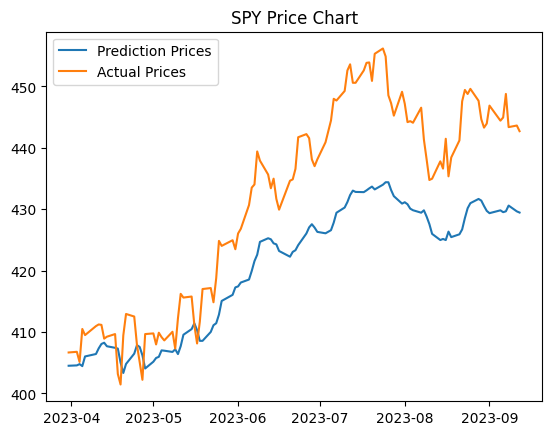

,Dates,SPY_nn,SPY,unrealized returns/losses,Buy/Sell,TotalCash,AssetValue
0,2023-03-31,404.497620,406.659668,0.000000,1,340.470741,39445.987793
1,2023-04-03,404.556061,406.768860,0.109192,0,340.470741,39456.579407
2,2023-04-04,404.764709,405.110901,-1.548767,0,340.470741,39295.757385
3,2023-04-05,404.436646,410.491882,3.832214,0,340.470741,39817.712585
4,2023-04-06,406.011597,409.489136,2.829468,0,340.470741,39720.446167
...,...,...,...,...,...,...,...
108,2023-09-06,429.513428,444.940552,26.863739,0,57.793800,42269.352417
109,2023-09-07,429.655853,448.777008,30.700195,0,57.793800,42633.815765
110,2023-09-08,430.591431,443.369995,25.293182,0,57.793800,42120.149536
111,2023-09-11,429.645660,443.630005,25.553192,0,57.793800,42144.850464


In [24]:
priceData = buildNeuralNetwork("SPY",START_DATE, END_DATE)
dfLag = calcReturnsWithLag(priceData,weights)["SPY"]
dfLag

In [25]:
dfNoLag = calcReturnsWithNoLag(priceData,weights)["SPY"]
dfNoLag

,Dates,SPY_nn,SPY,unrealized returns/losses,Buy/Sell,TotalCash,AssetValue
0,2023-03-31,404.497620,406.659668,0.000000,1,340.470741,39445.987793
1,2023-04-03,404.556061,406.768860,0.109192,0,340.470741,39456.579407
2,2023-04-04,404.764709,405.110901,-1.548767,0,340.470741,39295.757385
3,2023-04-05,404.436646,410.491882,3.832214,0,340.470741,39817.712585
4,2023-04-06,406.011597,409.489136,2.829468,0,340.470741,39720.446167
...,...,...,...,...,...,...,...
108,2023-09-06,429.513428,444.940552,40.832428,0,176.307166,43604.174072
109,2023-09-07,429.655853,448.777008,44.668884,0,176.307166,43980.146790
110,2023-09-08,430.591431,443.369995,39.261871,0,176.307166,43450.259521
111,2023-09-11,429.645660,443.630005,39.521881,0,176.307166,43475.740479


### The following Markdown was used for testing purposes

START_DATE = '2020-09-20' # Stock data start date 
END_DATE = '2023-09-20' # Stock data end date
data = {}
unrealized = buildNeuralNetwork("AAPL",START_DATE,END_DATE)
values = list(unrealized.items())
data['Dates']= values[-1][1]   
first,second = values[0][0],values[1][0]
data[first] = values[0][1]   
data[second] = values[1][1]
test = pd.DataFrame(data)
specificWeight = weights.get(second)
totalCash = specificWeight*200000
#########################################################
 For This Code, I  calculated unrealized gains and losses 
 for each stock. When writing my code, I assumed that there
 would be some sort of lag when executing orders
#########################################################
x = list(test.columns)
values = []
buySell = []
cash = []
assets = []
initialReturns = 0
shares = 0
holding = True
future = False
for index, row in test.iterrows():
    if (row[x[1]] < row[x[2]]):
        if(holding and index !=0):
            previousPrice = float(test.loc[index-1][x[2]])
            initialReturns = (row[x[2]] - previousPrice) + initialReturns
            assets.append(shares*row[x[2]])
            values.append(initialReturns)
            cash.append(totalCash)
            buySell.append(0)
        else:
            initialReturns = initialReturns
            shares = totalCash/row[x[2]]
            moneyInAssets = shares * row[x[2]]
            assets.append(moneyInAssets)
            values.append(initialReturns)
            totalCash = totalCash % row[x[2]]
            buySell.append(1)
            cash.append(totalCash)
            holding = True
    else:
        if(holding):
            if(index !=0):
                previousPrice = float(test.loc[index-1][x[2]])
                initialReturns = (row[x[2]] - previousPrice) + initialReturns
                values.append(initialReturns)
                totalCash = shares * row[x[2]]
                assets.append(0)
                buySell.append(-1)
                cash.append(totalCash)
            else:
                initialReturns = 0
                values.append(initialReturns)
                buySell.append(0)
                assets.append(0)
                cash.append(totalCash)
            holding = False
        else:
            values.append(initialReturns)
            buySell.append(0)
            assets.append(0)
            cash.append(totalCash)
test["unrealized returns/losses"] =  values
test["Buy/Sell"] = buySell
test["TotalCash"] = cash
test['AssetValue'] = assets
test.to_excel("test.xlsx")

### Implementing the Neural Network on all of the Stocks. 

The Graphs featured below are examples of the test data

[*********************100%%**********************]  1 of 1 completed
Epoch 1/1000
17/17 [==============================] - 4s 46ms/step - loss: 20638.8359 - mean_squared_error: 20638.8359 - val_loss: 20798.1543 - val_mean_squared_error: 20798.1543
Epoch 2/1000
17/17 [==============================] - 0s 7ms/step - loss: 19768.6738 - mean_squared_error: 19768.6738 - val_loss: 19322.1602 - val_mean_squared_error: 19322.1602
Epoch 3/1000
17/17 [==============================] - 0s 7ms/step - loss: 17210.1699 - mean_squared_error: 17210.1699 - val_loss: 14841.4580 - val_mean_squared_error: 14841.4580
Epoch 4/1000
17/17 [==============================] - 0s 7ms/step - loss: 10272.7051 - mean_squared_error: 10272.7051 - val_loss: 4662.2251 - val_mean_squared_error: 4662.2251
Epoch 5/1000
17/17 [==============================] - 0s 7ms/step - loss: 1535.9860 - mean_squared_error: 1535.9860 - val_loss: 578.4910 - val_mean_squared_error: 578.4910
Epoch 6/1000
17/17 [============================

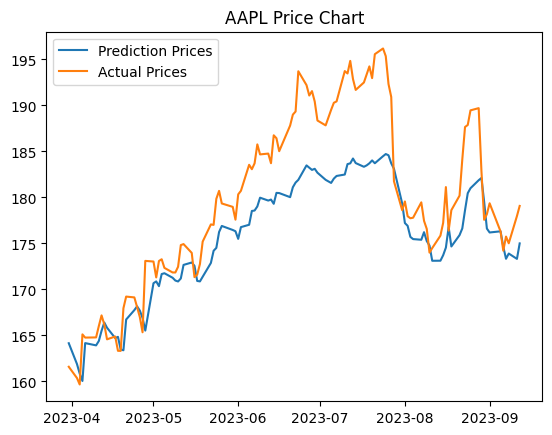

[*********************100%%**********************]  1 of 1 completed
Epoch 1/1000
17/17 [==============================] - 6s 63ms/step - loss: 23342.3574 - mean_squared_error: 23342.3574 - val_loss: 8841.2900 - val_mean_squared_error: 8841.2900
Epoch 2/1000
17/17 [==============================] - 0s 11ms/step - loss: 22910.9434 - mean_squared_error: 22910.9434 - val_loss: 8369.5771 - val_mean_squared_error: 8369.5771
Epoch 3/1000
17/17 [==============================] - 0s 15ms/step - loss: 21431.2793 - mean_squared_error: 21431.2793 - val_loss: 6533.2104 - val_mean_squared_error: 6533.2104
Epoch 4/1000
17/17 [==============================] - 0s 11ms/step - loss: 15831.6514 - mean_squared_error: 15831.6514 - val_loss: 1594.5275 - val_mean_squared_error: 1594.5275
Epoch 5/1000
17/17 [==============================] - 0s 9ms/step - loss: 4315.1069 - mean_squared_error: 4315.1069 - val_loss: 6156.2085 - val_mean_squared_error: 6156.2085
Epoch 6/1000
17/17 [=============================

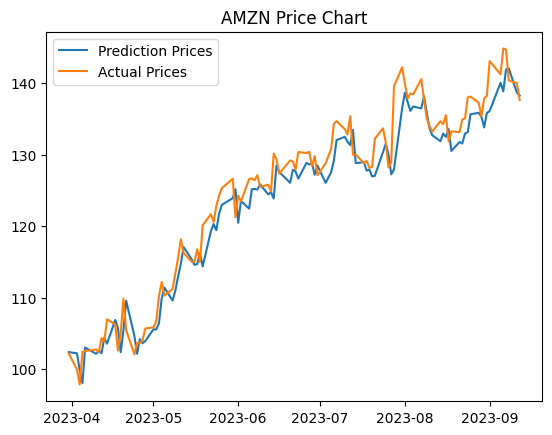

[*********************100%%**********************]  1 of 1 completed
Epoch 1/1000
17/17 [==============================] - 6s 62ms/step - loss: 73373.3984 - mean_squared_error: 73373.3984 - val_loss: 24703.2246 - val_mean_squared_error: 24703.2246
Epoch 2/1000
17/17 [==============================] - 0s 11ms/step - loss: 71965.7500 - mean_squared_error: 71965.7500 - val_loss: 23223.7578 - val_mean_squared_error: 23223.7578
Epoch 3/1000
17/17 [==============================] - 0s 11ms/step - loss: 67405.2188 - mean_squared_error: 67405.2188 - val_loss: 18579.7949 - val_mean_squared_error: 18579.7949
Epoch 4/1000
17/17 [==============================] - 0s 11ms/step - loss: 53784.2383 - mean_squared_error: 53784.2383 - val_loss: 7578.4126 - val_mean_squared_error: 7578.4126
Epoch 5/1000
17/17 [==============================] - 0s 10ms/step - loss: 24699.6621 - mean_squared_error: 24699.6621 - val_loss: 4615.4780 - val_mean_squared_error: 4615.4780
Epoch 6/1000
17/17 [====================

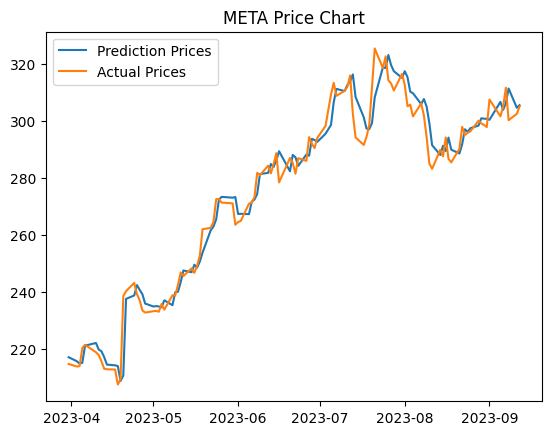

[*********************100%%**********************]  1 of 1 completed
Epoch 1/1000
17/17 [==============================] - 6s 62ms/step - loss: 69834.6641 - mean_squared_error: 69834.6641 - val_loss: 63242.6211 - val_mean_squared_error: 63242.6211
Epoch 2/1000
17/17 [==============================] - 0s 11ms/step - loss: 69060.6172 - mean_squared_error: 69060.6172 - val_loss: 62018.2695 - val_mean_squared_error: 62018.2695
Epoch 3/1000
17/17 [==============================] - 0s 10ms/step - loss: 66778.1641 - mean_squared_error: 66778.1641 - val_loss: 58247.1758 - val_mean_squared_error: 58247.1758
Epoch 4/1000
17/17 [==============================] - 0s 10ms/step - loss: 59844.2500 - mean_squared_error: 59844.2500 - val_loss: 47276.3164 - val_mean_squared_error: 47276.3164
Epoch 5/1000
17/17 [==============================] - 0s 11ms/step - loss: 42133.9570 - mean_squared_error: 42133.9570 - val_loss: 22919.6094 - val_mean_squared_error: 22919.6094
Epoch 6/1000
17/17 [================

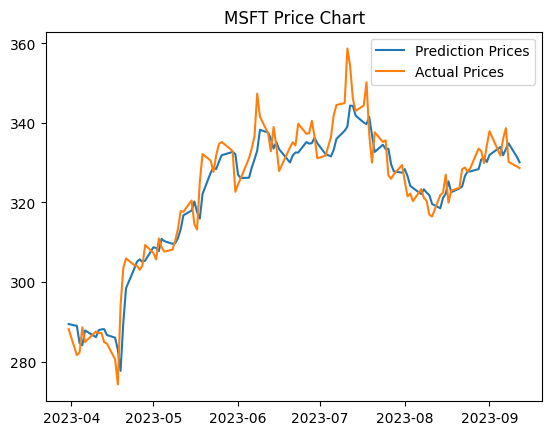

[*********************100%%**********************]  1 of 1 completed
Epoch 1/1000
17/17 [==============================] - 6s 64ms/step - loss: 37036.8984 - mean_squared_error: 37036.8984 - val_loss: 42158.9180 - val_mean_squared_error: 42158.9180
Epoch 2/1000
17/17 [==============================] - 0s 10ms/step - loss: 36650.8398 - mean_squared_error: 36650.8398 - val_loss: 41362.0117 - val_mean_squared_error: 41362.0117
Epoch 3/1000
17/17 [==============================] - 0s 10ms/step - loss: 35040.7852 - mean_squared_error: 35040.7852 - val_loss: 37808.5156 - val_mean_squared_error: 37808.5156
Epoch 4/1000
17/17 [==============================] - 0s 10ms/step - loss: 28453.2012 - mean_squared_error: 28453.2012 - val_loss: 24479.5020 - val_mean_squared_error: 24479.5020
Epoch 5/1000
17/17 [==============================] - 0s 11ms/step - loss: 11195.4473 - mean_squared_error: 11195.4473 - val_loss: 2207.0388 - val_mean_squared_error: 2207.0388
Epoch 6/1000
17/17 [==================

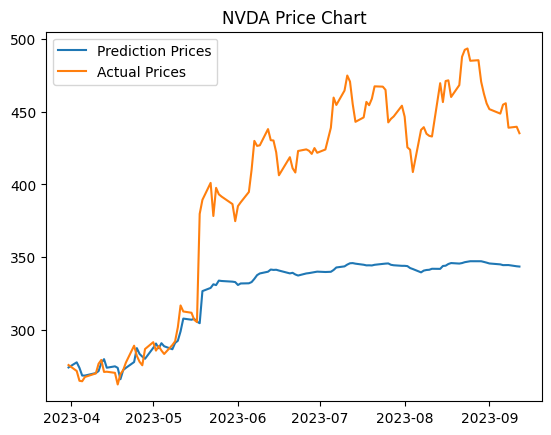

[*********************100%%**********************]  1 of 1 completed
Epoch 1/1000
17/17 [==============================] - 4s 51ms/step - loss: 68453.5000 - mean_squared_error: 68453.5000 - val_loss: 29591.0840 - val_mean_squared_error: 29591.0840
Epoch 2/1000
17/17 [==============================] - 0s 8ms/step - loss: 67317.3281 - mean_squared_error: 67317.3281 - val_loss: 28286.4512 - val_mean_squared_error: 28286.4512
Epoch 3/1000
17/17 [==============================] - 0s 8ms/step - loss: 63648.9844 - mean_squared_error: 63648.9844 - val_loss: 23862.9434 - val_mean_squared_error: 23862.9434
Epoch 4/1000
17/17 [==============================] - 0s 8ms/step - loss: 51316.8125 - mean_squared_error: 51316.8125 - val_loss: 11046.7188 - val_mean_squared_error: 11046.7188
Epoch 5/1000
17/17 [==============================] - 0s 7ms/step - loss: 23444.2090 - mean_squared_error: 23444.2090 - val_loss: 1597.4291 - val_mean_squared_error: 1597.4291
Epoch 6/1000
17/17 [======================

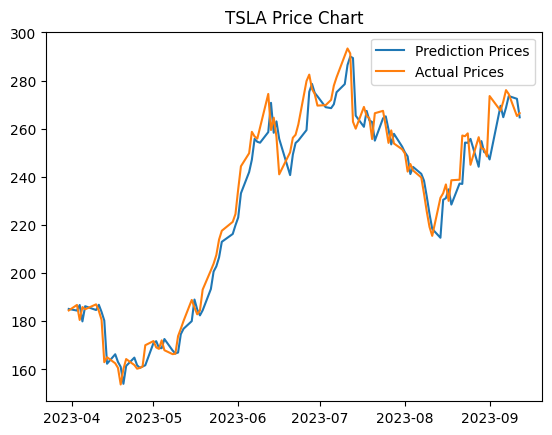

[*********************100%%**********************]  1 of 1 completed
Epoch 1/1000
17/17 [==============================] - 3s 43ms/step - loss: 14078.1758 - mean_squared_error: 14078.1758 - val_loss: 9092.7539 - val_mean_squared_error: 9092.7539
Epoch 2/1000
17/17 [==============================] - 0s 6ms/step - loss: 13677.8623 - mean_squared_error: 13677.8623 - val_loss: 8513.0635 - val_mean_squared_error: 8513.0635
Epoch 3/1000
17/17 [==============================] - 0s 6ms/step - loss: 12382.9922 - mean_squared_error: 12382.9922 - val_loss: 6490.4863 - val_mean_squared_error: 6490.4863
Epoch 4/1000
17/17 [==============================] - 0s 6ms/step - loss: 8016.7471 - mean_squared_error: 8016.7480 - val_loss: 1232.6611 - val_mean_squared_error: 1232.6611
Epoch 5/1000
17/17 [==============================] - 0s 6ms/step - loss: 1458.2053 - mean_squared_error: 1458.2053 - val_loss: 1716.6893 - val_mean_squared_error: 1716.6893
Epoch 6/1000
17/17 [==============================] - 

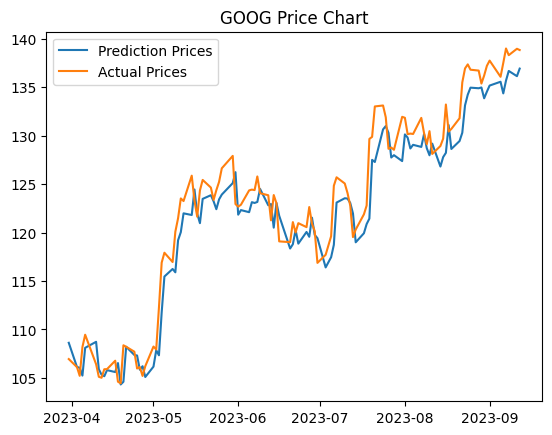

[*********************100%%**********************]  1 of 1 completed
Epoch 1/1000
17/17 [==============================] - 3s 28ms/step - loss: 4458.1973 - mean_squared_error: 4458.1973 - val_loss: 11471.2236 - val_mean_squared_error: 11471.2236
Epoch 2/1000
17/17 [==============================] - 0s 4ms/step - loss: 4264.6382 - mean_squared_error: 4264.6382 - val_loss: 10894.4834 - val_mean_squared_error: 10894.4834
Epoch 3/1000
17/17 [==============================] - 0s 4ms/step - loss: 3486.5867 - mean_squared_error: 3486.5867 - val_loss: 8387.1221 - val_mean_squared_error: 8387.1221
Epoch 4/1000
17/17 [==============================] - 0s 4ms/step - loss: 1472.4867 - mean_squared_error: 1472.4867 - val_loss: 2585.5916 - val_mean_squared_error: 2585.5916
Epoch 5/1000
17/17 [==============================] - 0s 4ms/step - loss: 542.4339 - mean_squared_error: 542.4339 - val_loss: 2024.1157 - val_mean_squared_error: 2024.1157
Epoch 6/1000
17/17 [==============================] - 0s 4

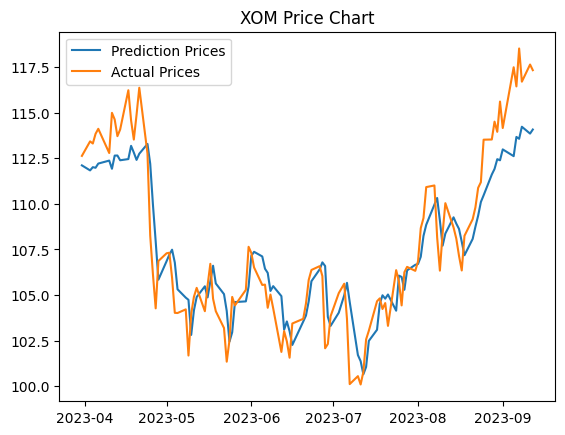

[*********************100%%**********************]  1 of 1 completed
Epoch 1/1000
17/17 [==============================] - 2s 30ms/step - loss: 17258.5977 - mean_squared_error: 17258.5977 - val_loss: 17281.1074 - val_mean_squared_error: 17281.1074
Epoch 2/1000
17/17 [==============================] - 0s 5ms/step - loss: 16889.5293 - mean_squared_error: 16889.5293 - val_loss: 16632.7344 - val_mean_squared_error: 16632.7344
Epoch 3/1000
17/17 [==============================] - 0s 5ms/step - loss: 15708.1943 - mean_squared_error: 15708.1943 - val_loss: 14568.2061 - val_mean_squared_error: 14568.2061
Epoch 4/1000
17/17 [==============================] - 0s 4ms/step - loss: 12189.6025 - mean_squared_error: 12189.6025 - val_loss: 8608.2061 - val_mean_squared_error: 8608.2061
Epoch 5/1000
17/17 [==============================] - 0s 5ms/step - loss: 4016.9778 - mean_squared_error: 4016.9778 - val_loss: 38.5599 - val_mean_squared_error: 38.5599
Epoch 6/1000
17/17 [==============================

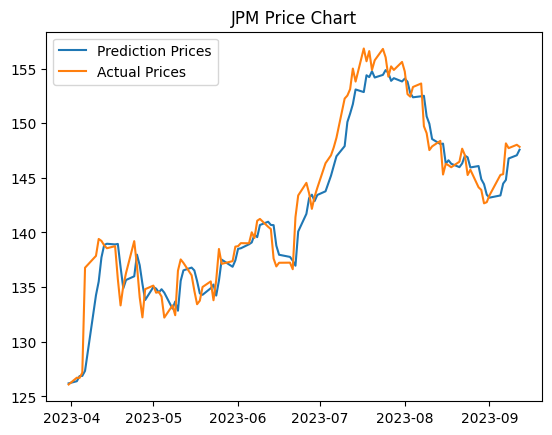

[*********************100%%**********************]  1 of 1 completed
Epoch 1/1000
17/17 [==============================] - 3s 34ms/step - loss: 24879.5449 - mean_squared_error: 24879.5449 - val_loss: 26559.9199 - val_mean_squared_error: 26559.9199
Epoch 2/1000
17/17 [==============================] - 0s 4ms/step - loss: 24503.0215 - mean_squared_error: 24503.0215 - val_loss: 25802.7910 - val_mean_squared_error: 25802.7910
Epoch 3/1000
17/17 [==============================] - 0s 4ms/step - loss: 23012.5547 - mean_squared_error: 23012.5547 - val_loss: 22940.2344 - val_mean_squared_error: 22940.2344
Epoch 4/1000
17/17 [==============================] - 0s 4ms/step - loss: 18378.9707 - mean_squared_error: 18378.9707 - val_loss: 15200.4814 - val_mean_squared_error: 15200.4814
Epoch 5/1000
17/17 [==============================] - 0s 4ms/step - loss: 7949.6899 - mean_squared_error: 7949.6899 - val_loss: 1884.0079 - val_mean_squared_error: 1884.0079
Epoch 6/1000
17/17 [========================

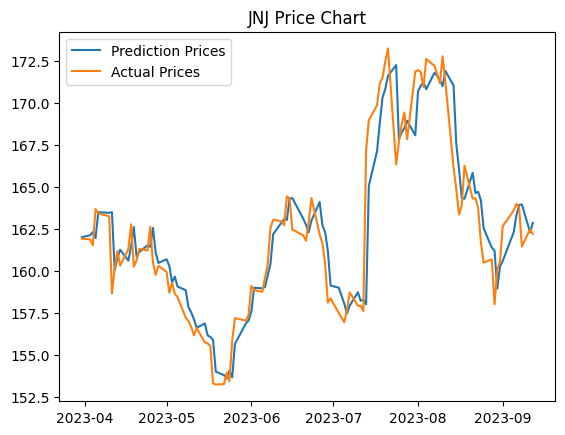

[*********************100%%**********************]  1 of 1 completed
Epoch 1/1000
17/17 [==============================] - 3s 32ms/step - loss: 159324.6406 - mean_squared_error: 159324.6406 - val_loss: 152544.6875 - val_mean_squared_error: 152544.6875
Epoch 2/1000
17/17 [==============================] - 0s 6ms/step - loss: 156263.1406 - mean_squared_error: 156263.1406 - val_loss: 147087.9219 - val_mean_squared_error: 147087.9219
Epoch 3/1000
17/17 [==============================] - 0s 4ms/step - loss: 144882.5938 - mean_squared_error: 144882.5938 - val_loss: 127754.1250 - val_mean_squared_error: 127754.1250
Epoch 4/1000
17/17 [==============================] - 0s 4ms/step - loss: 114151.3828 - mean_squared_error: 114151.3828 - val_loss: 80709.1250 - val_mean_squared_error: 80709.1250
Epoch 5/1000
17/17 [==============================] - 0s 4ms/step - loss: 51466.3555 - mean_squared_error: 51466.3555 - val_loss: 11850.2930 - val_mean_squared_error: 11850.2930
Epoch 6/1000
17/17 [======

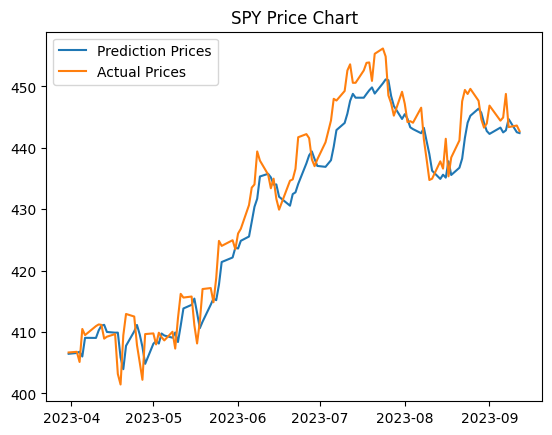

In [26]:
START_DATE = '2020-09-20' # Stock data start date 
END_DATE = '2023-09-20' # Stock data end date
listOfDfs = {}
dataWithNoLag = {}
dataWithLag = {}
for x in range(len(tickers)):
    priceData = buildNeuralNetwork(tickers[x],START_DATE, END_DATE)
    unrealizedReturnsNoLag = calcReturnsWithNoLag(priceData,weights)
    unrealizedReturnsLag = calcReturnsWithLag(priceData,weights)
    listOfUnrealizedReturnsNoLag = list(unrealizedReturnsNoLag.items())
    listOfUnrealizedReturnsLag = list(unrealizedReturnsLag.items())
    dataWithNoLag[listOfUnrealizedReturnsNoLag[0][0]] = listOfUnrealizedReturnsNoLag[0][1]
    dataWithLag[listOfUnrealizedReturnsLag[0][0]] = listOfUnrealizedReturnsLag[0][1]

In [27]:
dataWithNoLag

{'AAPL':          Dates     AAPL_nn        AAPL  unrealized returns/losses  Buy/Sell  \
 0   2023-03-31  164.148224  161.587982                   0.000000         0   
 1   2023-04-03  161.887772  160.361343                   0.000000         0   
 2   2023-04-04  160.846527  159.663254                   0.000000         0   
 3   2023-04-05  160.042236  165.108353                   0.000000         1   
 4   2023-04-06  164.160492  164.759323                  -0.349030         0   
 ..         ...         ...         ...                        ...       ...   
 108 2023-09-06  174.636047  174.210007                  32.536133         0   
 109 2023-09-07  173.326233  175.740005                  32.536133         1   
 110 2023-09-08  173.895660  175.009995                  31.806122         0   
 111 2023-09-11  173.315643  177.970001                  34.766129         0   
 112 2023-09-12  174.997681  179.070007                  35.866135         0   
 
         TotalCash    AssetVal

In [28]:
dataWithLag

{'AAPL':          Dates     AAPL_nn        AAPL  unrealized returns/losses  Buy/Sell  \
 0   2023-03-31  164.148224  161.587982                   0.000000         0   
 1   2023-04-03  161.887772  160.361343                   0.000000         0   
 2   2023-04-04  160.846527  159.663254                   0.000000         0   
 3   2023-04-05  160.042236  165.108353                   0.000000         1   
 4   2023-04-06  164.160492  164.759323                  -0.349030         0   
 ..         ...         ...         ...                        ...       ...   
 108 2023-09-06  174.636047  174.210007                   1.431839         0   
 109 2023-09-07  173.326233  175.740005                   1.431839         1   
 110 2023-09-08  173.895660  175.009995                   0.701828         0   
 111 2023-09-11  173.315643  177.970001                   3.661835         0   
 112 2023-09-12  174.997681  179.070007                   4.761841         0   
 
         TotalCash    AssetVal

### Building the Final Dataframe

Calculated Total Asset Value, Total Cash Value, Portfolio Value, totalGainsAndLosses, and the liquidity ratio of the portfolio

In [29]:
symbols = list(dataWithNoLag.keys())
valsNoLag = list(dataWithNoLag.values())
valsLag = list(dataWithLag.values())
portfolioDataNoLag = {}
portfolioDataLag = {}
assetNums = []
cashNums = []
for x in range(len(dataWithNoLag)):
    name = symbols[x] + "AssetValue"
    portfolioDataNoLag[name] = valsNoLag[x]["AssetValue"]
    cashAndName = symbols[x] +" Cash"
    portfolioDataNoLag[cashAndName] = valsNoLag[x]["TotalCash"]
    portfolioDataLag[name] =  valsLag[x]["AssetValue"]
    portfolioDataLag[cashAndName] = valsLag[x]["TotalCash"]


finalDfNoLag = pd.DataFrame(portfolioDataNoLag)
finalDfLag = pd.DataFrame(portfolioDataLag)
newColumns = finalDfNoLag.columns
cashColumn = []
assetColumn = []
for i in range(len(newColumns)):
    if "Cash" in newColumns[i]:
        cashColumn.append(newColumns[i])
    if "Asset" in newColumns[i]:
        assetColumn.append(newColumns[i])
### NO LAG Dataframe
finalDfNoLag["TotalAssetValue"] = finalDfNoLag.loc[:,assetColumn].sum(axis=1)
finalDfNoLag["TotalCashValue"] = finalDfNoLag.loc[:,cashColumn].sum(axis=1)
finalDfNoLag["PortfolioValue"] = finalDfNoLag["TotalCashValue"] + finalDfNoLag["TotalAssetValue"]
finalDfNoLag["gainsAndLosses"] = finalDfNoLag["PortfolioValue"] - 200000
finalDfNoLag["Date"] =  valsNoLag[0]["Dates"]
finalDfNoLag["Liquidity"] = finalDfNoLag["TotalCashValue"] / finalDfNoLag["PortfolioValue"]

### LAG Dataframe
finalDfLag["TotalAssetValue"] = finalDfLag.loc[:,assetColumn].sum(axis=1)
finalDfLag["TotalCashValue"] = finalDfLag.loc[:,cashColumn].sum(axis=1)
finalDfLag["PortfolioValue"] = finalDfLag["TotalCashValue"] + finalDfLag["TotalAssetValue"]
finalDfLag["gainsAndLosses"] = finalDfLag["PortfolioValue"] - 200000
finalDfLag["Date"] =  valsLag[0]["Dates"]
finalDfLag["Liquidity"] = finalDfLag["TotalCashValue"] / finalDfLag["PortfolioValue"]

## Plot P/L

Text(0.5, 0, 'Date')

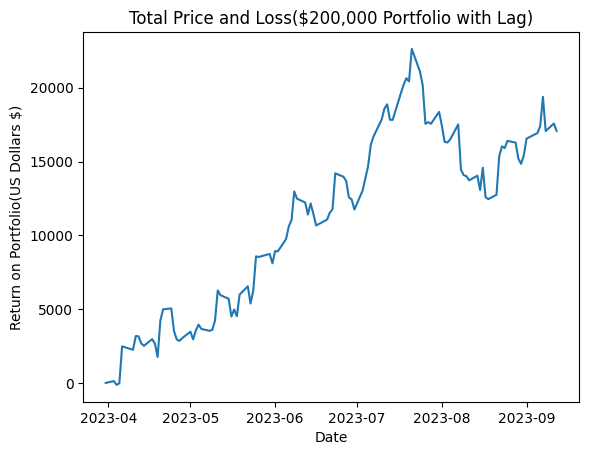

In [30]:
plt.plot(finalDfLag['Date'],finalDfLag["gainsAndLosses"])
plt.title("Total Price and Loss($200,000 Portfolio with Lag)")
plt.ylabel("Return on Portfolio(US Dollars $)")
plt.xlabel("Date")

Text(0.5, 0, 'Date')

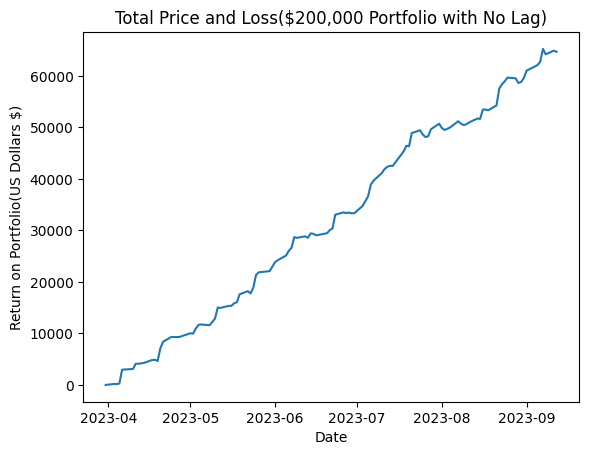

In [31]:
plt.plot(finalDfNoLag['Date'],finalDfNoLag["gainsAndLosses"])
plt.title("Total Price and Loss($200,000 Portfolio with No Lag)")
plt.ylabel("Return on Portfolio(US Dollars $)")
plt.xlabel("Date")

### Plotting the Returns against SPY benchmark

[*********************100%%**********************]  1 of 1 completed


C:\Users\shyam\AppData\Local\Temp\ipykernel_11052\1061446691.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spyShares = 200000  / spyData["Close"][0]


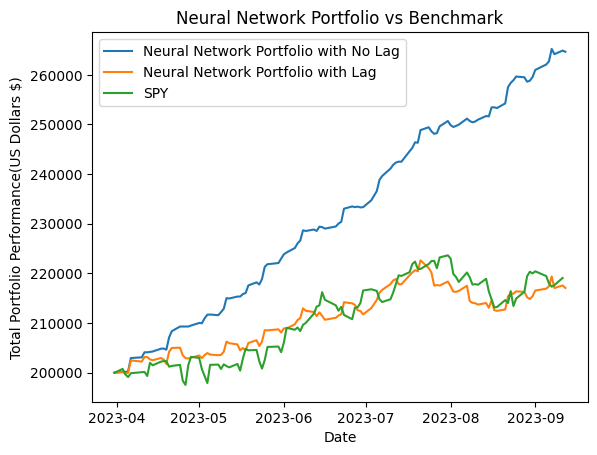

In [32]:
dates = list(finalDfNoLag['Date'])
start,end = dates[0],dates[-1]
spyData = pdr.get_data_yahoo("SPY",start,end)
newDates = spyData.index
spyShares = 200000  / spyData["Close"][0]
spyCloses = spyShares * spyData["Close"] 
plt.plot(finalDfNoLag['Date'],finalDfNoLag["PortfolioValue"])
plt.plot(finalDfLag['Date'],finalDfLag["PortfolioValue"])
plt.plot(newDates,spyCloses)
plt.title("Neural Network Portfolio vs Benchmark")
plt.ylabel("Total Portfolio Performance(US Dollars $)")
plt.xlabel("Date")
plt.legend(["Neural Network Portfolio with No Lag","Neural Network Portfolio with Lag","SPY"])


Model performed slightly worse than the S&P 500 over the last 6 months. To make this model more efficient and have a stronger performance, there needs to be more statistical indicators implemented into the modeling of the algorithm. Being able to factor in inflation data, technical analysis, and sentiment analysis could definitely improve the model in the future. 

## Plot Liquidity

Text(0.5, 0, 'Date')

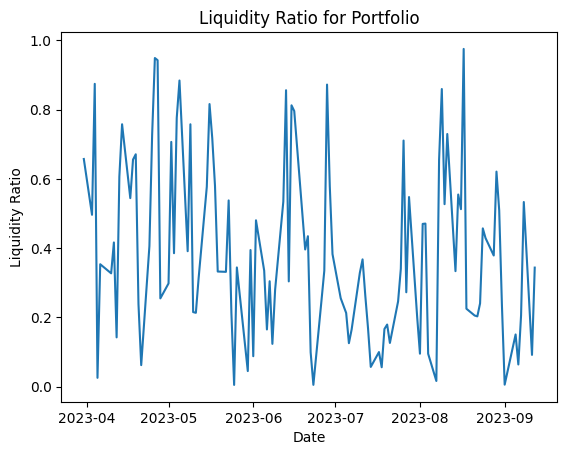

In [33]:
plt.plot(finalDfLag['Date'],finalDfLag["Liquidity"])
plt.title("Liquidity Ratio for Portfolio")
plt.ylabel("Liquidity Ratio")
plt.xlabel("Date")